In [1]:
# Mount drive
import os
from google.colab import drive
%cd /content
drive.mount('/content/drive', force_remount=True)
%cd 'drive/My Drive/Colab Notebooks/NLP/project/code'
%ls -l
print(os.listdir())

/content
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/NLP/project/code
total 162
-rw------- 1 root root  3534 Apr 22 16:32 cleaning.py
-rw------- 1 root root 21800 Apr 25 09:06 pytorch_tuto.ipynb
-rw------- 1 root root 22808 Apr 22 16:46 Untitled.ipynb
-rw------- 1 root root  3545 Apr 22 16:32 utils_cleaning.py
-rw------- 1 root root 20191 Apr 27 07:51 Vincent_doc2vec.ipynb
-rw------- 1 root root 20152 Apr 25 16:47 Vincent.ipynb
-rw------- 1 root root 71703 Apr 28 

In [2]:
!pip install -U sentence-transformers

     |████████████████████████████████| 61kB 2.4MB/s 
     |████████████████████████████████| 573kB 9.8MB/s 
     |████████████████████████████████| 1.0MB 59.2MB/s 
     |████████████████████████████████| 3.7MB 46.1MB/s 
     |████████████████████████████████| 890kB 47.4MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-0.2.6.1-cp36-none-any.whl size=74031 sha256=a14d2b29e962c12cd05e88fe69d7b890a465f0a23e0c4c9dd6d77d9a001fe8ce
  Stored in directory: /root/.cache/pip/wheels/d7/fa/17/2b081a8cd8b0a86753fb0e9826b3cc19f0207062c0b2da7008
  Created wheel for sacremoses: filename=sacremoses-0.0.41-cp36-none-any.whl size=893334 sha256=ff5fec3f2f7a7d34451b4e5a28bf5b2fd2d23cc159ce255682680a65b528cab5
  Stored in directory: /root/.cache/pip/wheels/22/5a/d4/b020a81249de7dc63758a34222feaa668dbe8ebfe9170cc9b1
Successfully built sentence-transformers sacremoses


In [0]:
import pandas as pd
import numpy as np
import random
import re
import time
from string import punctuation
import matplotlib.pyplot as plt

# import nltk
# from nltk.corpus import stopwords
# nltk.download('stopwords')
# from nltk.stem import SnowballStemmer
# nltk.download('punkt')
# from nltk.stem import WordNetLemmatizer 
# nltk.download('wordnet')
from nltk.tokenize import word_tokenize

# from gensim.test.utils import datapath, get_tmpfile
# from gensim.models import KeyedVectors
# from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

import torch
import torch.nn as nn
from torchtext.data import Field, LabelField, TabularDataset, Iterator, BucketIterator
from torchtext import vocab
import torch.optim as optim

In [0]:
EMBEDDING_PATH = '../data/embeddings/glove.6B.100d.txt'

In [5]:
train_data = pd.read_csv("../data/train.csv")
nrows = len(train_data)
train_data = train_data.dropna()
print('{} rows removed'.format(nrows-len(train_data)))

3 rows removed


In [6]:
train_data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [0]:
questions1 = train_data['question1'].values
questions2 = train_data['question2'].values
label = train_data['is_duplicate'].values

In [8]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('bert-base-nli-mean-tokens')

100%|██████████| 405M/405M [00:19<00:00, 21.1MB/s]


KeyboardInterrupt: ignored

In [0]:
[x for x in list(questions1) if isinstance(x, float)]

[nan]

In [0]:
%%time
sentence_embeddings1 = np.array(model.encode(questions1))
sentence_embeddings2 = np.array(model.encode(questions2))

CPU times: user 45min 31s, sys: 11min 41s, total: 57min 12s
Wall time: 57min 13s


In [0]:
np.save('../embeddings/SBERT1.npy', sentence_embeddings1)
np.save('../embeddings/SBERT2.npy', sentence_embeddings2)

In [0]:
sentence_embeddings1 = np.load('../embeddings/SBERT1.npy')
sentence_embeddings2 = np.load('../embeddings/SBERT2.npy')

In [0]:
emb1 = torch.Tensor(sentence_embeddings1)
emb2 = torch.Tensor(sentence_embeddings2)
target = torch.Tensor(label)

In [0]:
output = nn.CosineSimilarity()(emb1, emb2)

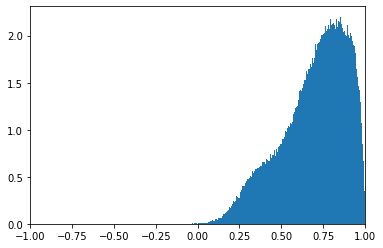

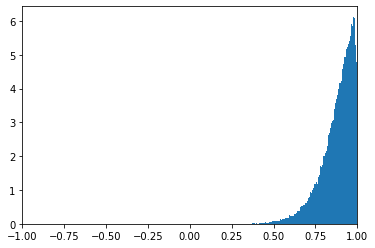

In [0]:
plt.hist(output[label==0], bins=201, density=True)
plt.xlim(-1,1)
plt.show()

plt.hist(output[label==1], bins=201, density=True)
plt.xlim(-1,1)
plt.show()

In [0]:
class siameseNet(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, input1, input2):
    output = nn.CosineSimilarity()(input1, input2)
    return output

In [0]:
model = siameseNet()
criterion = nn.BCEWithLogitsLoss()

In [0]:
losses = []
TPs = []
FPs = []
TNs = []
FNs = []

thresh = np.linspace(0,1,101)
model.eval()

predictions = model(emb1, emb2)
loss = criterion(predictions, target).item()

for t in thresh:
    predicted_labels = predictions >= t
    TP = ((predicted_labels==1) & (target==1)).sum().item()
    FP = ((predicted_labels==1) & (target==0)).sum().item()
    TN = ((predicted_labels==0) & (target==0)).sum().item()
    FN = ((predicted_labels==0) & (target==1)).sum().item()
    # epoch_TP_FN.append((predicted_labels==target).sum().item())
    # epoch_FP_TN.append((predicted_labels!=target).sum().item())

    TPs.append(TP)
    FPs.append(FP)
    TNs.append(TN)
    FNs.append(FN)

    # losses.append(loss.item())

TPs = np.array(TPs)
FPs = np.array(FPs)
TNs = np.array(TNs)
FNs = np.array(FNs)

0.8258775472640991


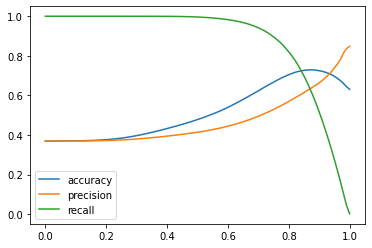

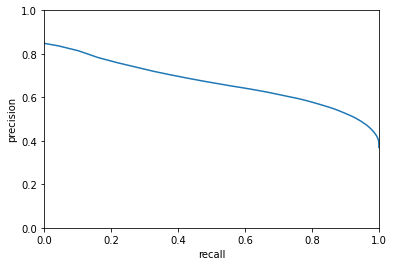

In [17]:
accuracies = (TPs+TNs)/(TPs+FPs+TNs+FNs)
precisions = TPs/(TPs+FPs)
recalls = TPs/(TPs+FNs)

print(loss)

plt.plot(thresh, accuracies, label='accuracy')
plt.plot(thresh, precisions, label='precision')
plt.plot(thresh, recalls, label='recall')
plt.legend()
plt.show()

plt.plot(recalls, precisions)
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('recall')
plt.ylabel('precision')
plt.show()

In [0]:
emb_shape = TEXT.vocab.vectors.shape
INPUT_DIM = emb_shape[0]
EMBEDDING_DIM = emb_shape[1]
HIDDEN_DIM = 50
OUTPUT_DIM = 1

model = siameseNet(vocab_size=INPUT_DIM, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, output_dim=OUTPUT_DIM)

pretrained_embeddings = TEXT.vocab.vectors
# model.embedding.weight.data.copy_(pretrained_embeddings)
model.embedding.from_pretrained(pretrained_embeddings, freeze=True)

optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCELoss()

model = model.to(device)
criterion = criterion.to(device)

In [0]:
def compute_accuracy(predictions, labels, thresh=0.5):
    predicted_labels = predictions >= thresh
    accuracy = (predicted_labels == labels).sum()/len(predictions)
    return accuracy.item()

def train(model, iterator, optimizer, criterion, thresh=0.5):
    # Track the loss
    epoch_loss = 0
    epoch_TP_FN = 0
    epoch_FP_TN = 0
    
    model.train()
    
    for batch in iterator:
        optimizer.zero_grad()
        
        predictions = model(batch.question1, batch.question2)
        loss = criterion(predictions, batch.is_duplicate)
        
        loss.backward()
        optimizer.step()

        predicted_labels = predictions >= thresh
        epoch_TP_FN += (predicted_labels==batch.is_duplicate).sum().item()
        epoch_FP_TN += (predicted_labels!=batch.is_duplicate).sum().item()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator), epoch_TP_FN/(epoch_TP_FN+epoch_FP_TN)


def evaluate(model, iterator, criterion, thresh=0.5):
    epoch_loss = 0
    epoch_TP_FN = 0
    epoch_FP_TN = 0
    
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            predictions = model(batch.question1, batch.question2)
            loss = criterion(predictions, batch.is_duplicate)

            predicted_labels = predictions >= thresh
            epoch_TP_FN += (predicted_labels==batch.is_duplicate).sum().item()
            epoch_FP_TN += (predicted_labels!=batch.is_duplicate).sum().item()

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator), epoch_TP_FN/(epoch_TP_FN+epoch_FP_TN)

In [0]:
N_EPOCHS = 6

# Track time taken
start_time = time.time()

for epoch in range(N_EPOCHS):
    epoch_start_time = time.time()
    
    train_loss, train_acc = train(model, train_iter, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iter, criterion)
    
    print(f'| Epoch: {epoch+1:02} '
          f'| Train Loss: {train_loss:.3f} '
          f'| Train Accuracy: {train_acc:.3f} '
          f'| Val. Loss: {valid_loss:.3f} '
          f'| Val. Accuracy: {valid_acc:.3f} '
          f'| Time taken: {time.time() - epoch_start_time:.2f}s'
          f'| Time elapsed: {time.time() - start_time:.2f}s')

| Epoch: 01 | Train Loss: 0.719 | Train Accuracy: 0.683 | Val. Loss: 0.724 | Val. Accuracy: 0.687 | Time taken: 101.26s| Time elapsed: 101.26s
| Epoch: 02 | Train Loss: 0.681 | Train Accuracy: 0.744 | Val. Loss: 0.702 | Val. Accuracy: 0.718 | Time taken: 101.83s| Time elapsed: 203.09s
| Epoch: 03 | Train Loss: 0.649 | Train Accuracy: 0.782 | Val. Loss: 0.685 | Val. Accuracy: 0.729 | Time taken: 102.28s| Time elapsed: 305.37s


KeyboardInterrupt: ignored